In [1]:
%load_ext autoreload
%autoreload 2  
%reload_ext autoreload

In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bgspy.recmap import RecMap
from bgspy.utils import load_seqlens

# Validation and Cleanup of the Hinch et al. Recombination Map

The source of the hg36 recombination map is [here](https://www.well.ox.ac.uk/~anjali/AAmap/). See the `Snakefile` for the processing of this. This is just to ensure the processing/liftover/scaling etc is correct. We need to remove some outliers.

In [3]:
hg38sl = load_seqlens('../data/annotation/hg38_seqlens.tsv')
chroms = list(hg38sl.keys())
hm = RecMap('../data/annotation/hapmap_genetic_map.txt', 
            seqlens=hg38sl)

In [4]:
hm

RecMap('../data/annotation/hapmap_genetic_map.txt')
 total length: 37.31 Morgans

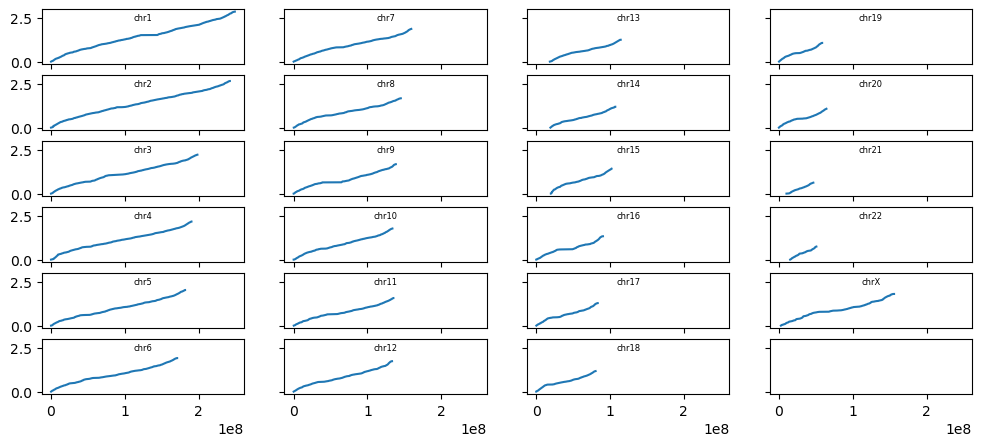

In [5]:
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 5), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    fax = ax[col, row]    
    hmcr = hm.cum_rates[chrom]
    fax.plot(hmcr.end, hmcr.rate)
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

In [6]:
d = pd.read_table('../data/annotation/aamap_hg38_raw.bed', sep='\t',
                  names=('chrom', 'start', 'end', 'rate'))
d.head()

,chrom,start,end,rate
0,chr1,817341,818802,6.134879e-12
1,chr1,818802,825532,4.800280e-12
2,chr1,825532,833068,5.329727e-12
3,chr1,833068,841166,6.317943e-12
4,chr1,841166,843942,4.908610e-12


## Filtering on Rates

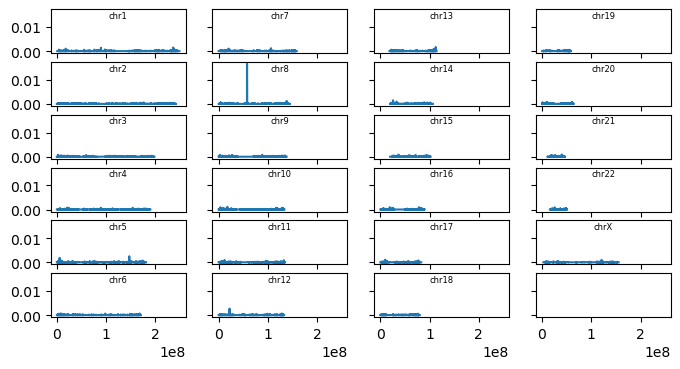

In [7]:
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(8, 4), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    dc = d.loc[d['chrom'] == chrom]
    #dc = dc[dc['rate'] < 0.002]
    fax = ax[col, row]
    fax.plot(0.5*(dc['start']+dc['end']), dc['rate'], label='raw Hinch et al. hg36')
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

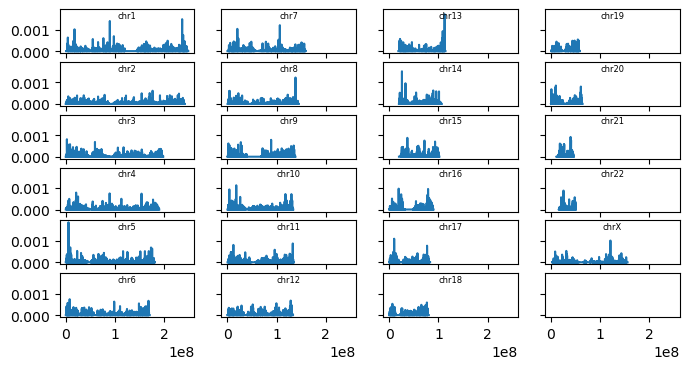

In [8]:
THRESH = 0.002
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(8, 4), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    dc = d.loc[d['chrom'] == chrom]
    dc = dc[dc['rate'] < THRESH]
    fax = ax[col, row]
    fax.plot(0.5*(dc['start']+dc['end']), dc['rate'], label='raw Hinch et al. hg36')
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

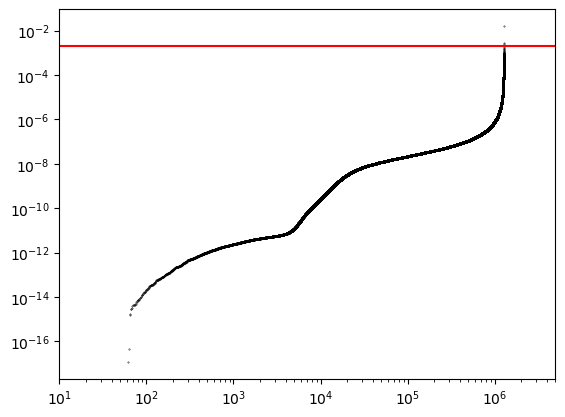

In [9]:
x = np.sort(d['rate'])
plt.scatter(np.arange(len(x)), x, s=0.1, c='k')
plt.loglog()
plt.xlim(10, 5e6)
plt.axhline(THRESH, c='r')

/tmp/ipykernel_25272/2361572667.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-8, 0)


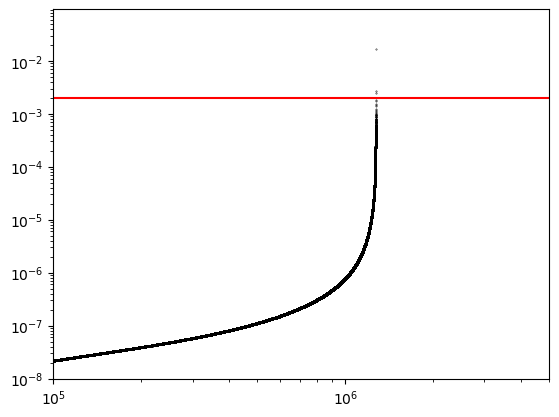

In [10]:
x = np.sort(d['rate'])
plt.scatter(np.arange(len(x)), x, s=0.1, c='k')
plt.loglog()
plt.xlim(1e5, 5e6)
plt.ylim(1e-8, 0)
plt.axhline(THRESH, c='r')

In [11]:
chroms = [f"chr{f}" for f in range(1, 23)]
def read(c):
    return pd.read_table(f"../data/annotation/AAmap/AAmap.{c}.txt", 
                         skiprows=1, sep=' ', 
                         names=('pos', 'rate'))
                         
raw_hirsh = {c: read(c) for c in chroms}

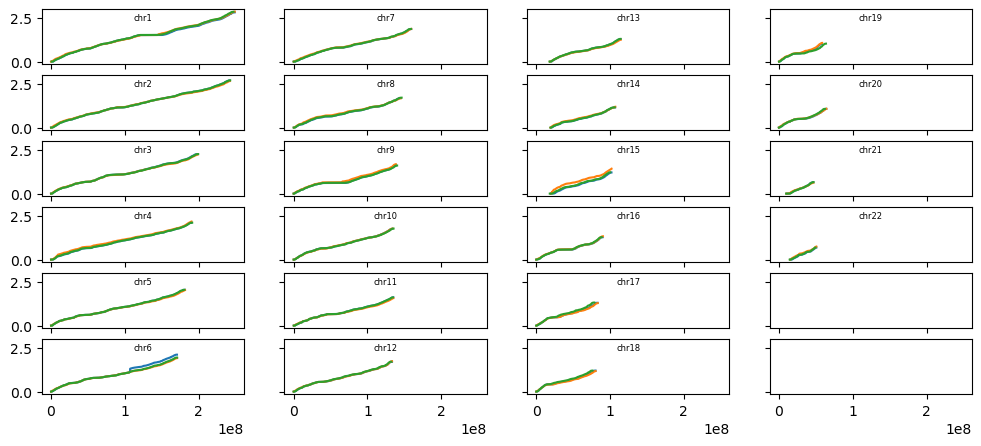

In [12]:
THRESH = 0.002
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 5), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    dc = d.loc[d['chrom'] == chrom]
    dc = dc[dc['rate'] < THRESH]
    dc = dc.sort_values(['start', 'end'])
    fax = ax[col, row]    
    fax.plot(dc['end'], 1/100 * np.cumsum(dc['rate'] * (dc['end']-dc['start'])), label='raw Hinch et al. hg36')
    
    hmcr = hm.cum_rates[chrom]
    fax.plot(hmcr.end, hmcr.rate)
    
    dh = raw_hirsh[chrom]
    x, y = dh['pos'], dh['rate']
    fax.plot(x, y/100)
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

## The chromosome 6 outlier

You can see chr6 has one more issue we need to clean up

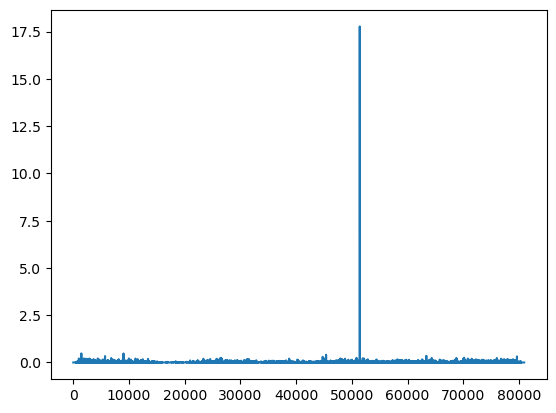

In [13]:
dc = d.loc[d['chrom'] == 'chr6']
dc = dc.sort_values(['start', 'end'])
dc['dist'] = dc['rate'] * (dc['end']-dc['start'])
dc['cumm'] = np.cumsum(dc['dist'])

ydiff = dc['cumm'].diff().values
plt.plot(ydiff)

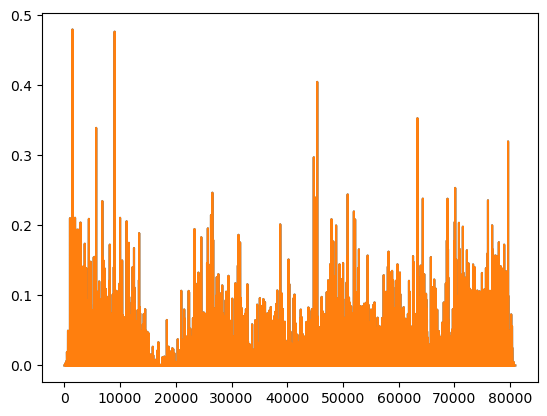

In [14]:
dc = d.loc[d['chrom'] == 'chr6']
dc = dc.sort_values(['start', 'end'])
dc['dist'] = dc['rate'] * (dc['end']-dc['start'])
# the filter has to go here
dc = dc.loc[dc['dist'] < 2.5]
dc['cumm'] = np.cumsum(dc['dist'])

ydiff = dc['cumm'].diff().values
plt.plot(ydiff)
plt.plot(ydiff[ydiff < 2.5])

In [ ]:
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 5), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    dc = d.loc[d['chrom'] == chrom]
    dc = dc[dc['rate'] < THRESH]
    dc = dc.sort_values(['start', 'end'])
    
    if chrom == 'chr6':
        # filter out the chr6 outlier
        dc = dc.loc[dc['dist'] < 2.5]
    
    fax = ax[col, row]    
    fax.plot(dc['end'], 1/100 * np.cumsum(dc['rate'] * (dc['end']-dc['start'])), label='raw Hinch et al. hg36')
    
    hmcr = hm.cum_rates[chrom]
    fax.plot(hmcr.end, hmcr.rate)
    
    dh = raw_hirsh[chrom]
    x, y = dh['pos'], dh['rate']
    fax.plot(x, y/100)
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

## Summary

 - Special filtering of chr6
 - General outlier filtering
 
 The following code is used in the snakemake pipeline.

In [64]:
fixed = []
for chrom, df in d.groupby('chrom'):
    #df = df.sort_values(['start', 'end'])
    # filter local rate outliers
    df = df.loc[df['rate'] < THRESH]
    df['dist'] = df['rate'] * (df['end']-df['start'])
    
    if chrom == 'chr6':
        # filter out the chr6 outlier
        df = df.loc[df['dist'] < 2.5]
    
    df['cum'] = np.cumsum(df['dist'])
    df['rate'] = np.array([0] + (np.diff(df['cum'])).tolist())
    df['rate'] = df['rate']/(df['end']-df['start'])

    # this is an important check that the end positions are in order
    bad = np.diff(df['end']) <= 0
    if bad.sum():
        bad_pos = set(np.where(bad)[0])
        keep_idx = list(set(np.arange(df.shape[0])))
        df = df.iloc[keep_idx, :]
    #assert bad_pos.sum() == 0, (chrom, np.where(bad_pos))
    fixed.append(df)

dfixed = pd.concat(fixed)

/tmp/ipykernel_25272/4206395284.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist'] = df['rate'] * (df['end']-df['start'])
/tmp/ipykernel_25272/4206395284.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cum'] = np.cumsum(df['dist'])
/tmp/ipykernel_25272/4206395284.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

## Validation

Now, let's analyze the results **as they come out of snakemake**.

In [65]:
rm = RecMap('../data/annotation/aamap_hg38.tsv', 
            seqlens=hg38sl, conversion_factor=1)

### All Validation Plots

/tmp/ipykernel_25272/1392592850.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, fax = plt.subplots(figsize=(12, 5), sharex=True, sharey=True)


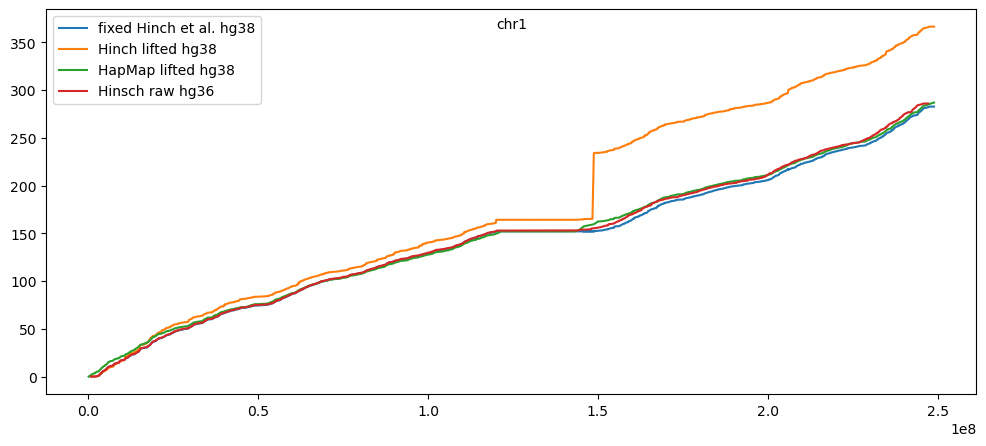

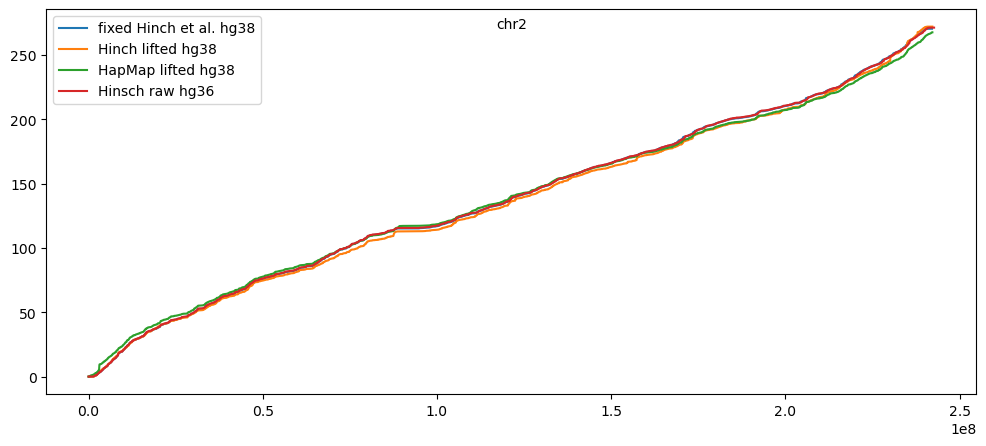

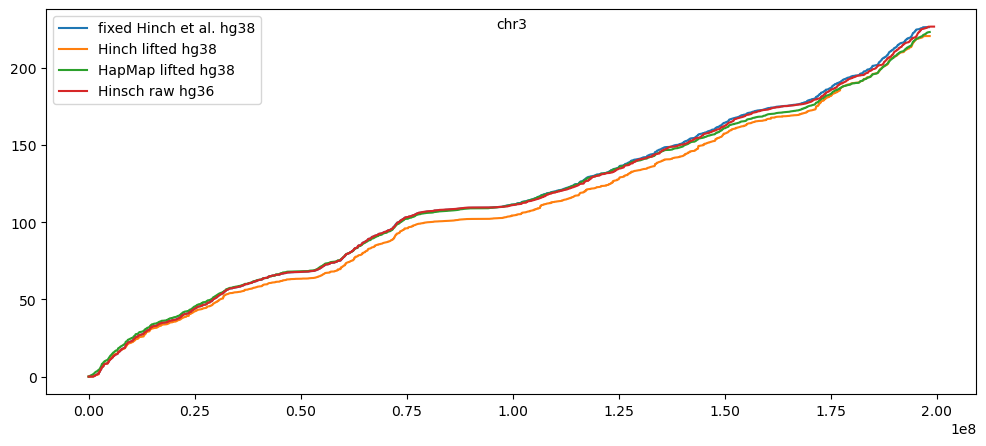

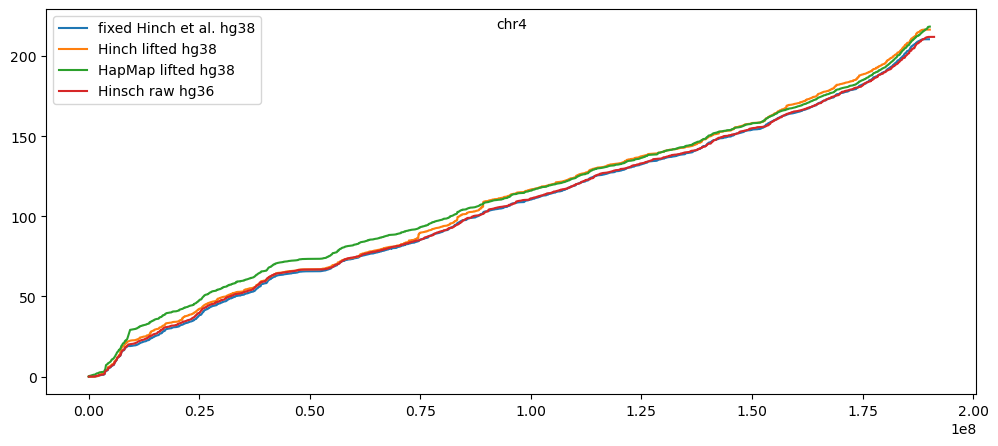

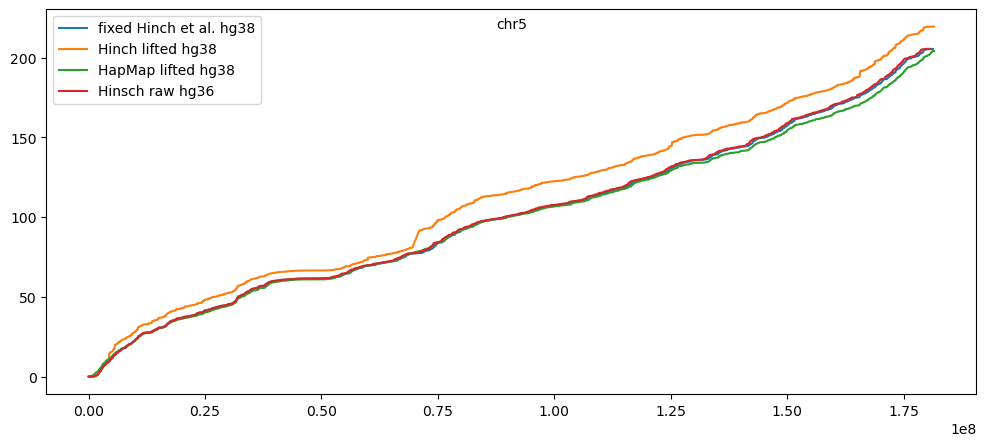

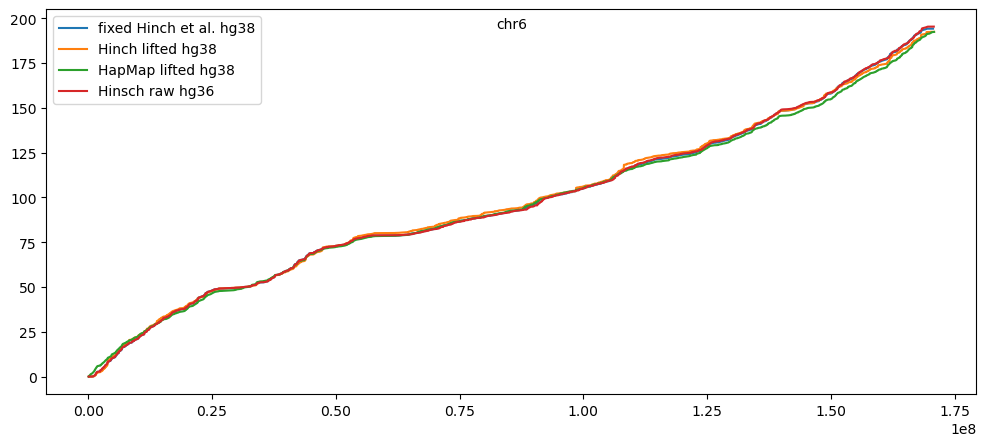

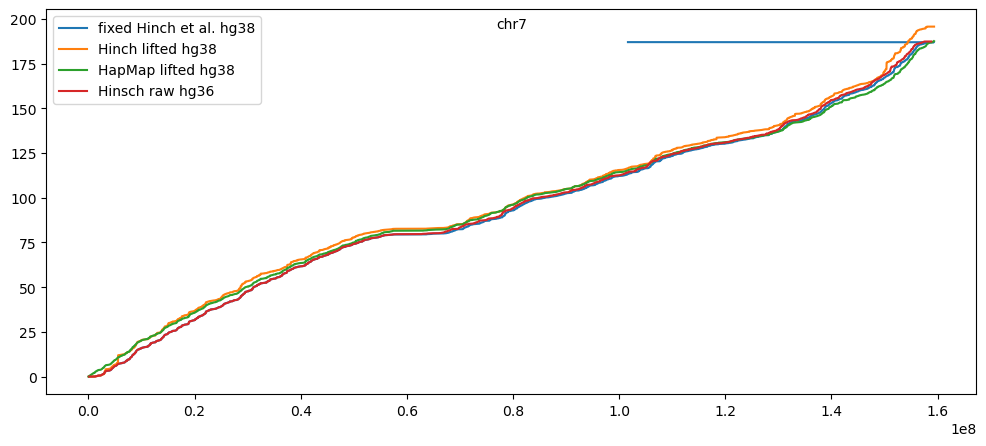

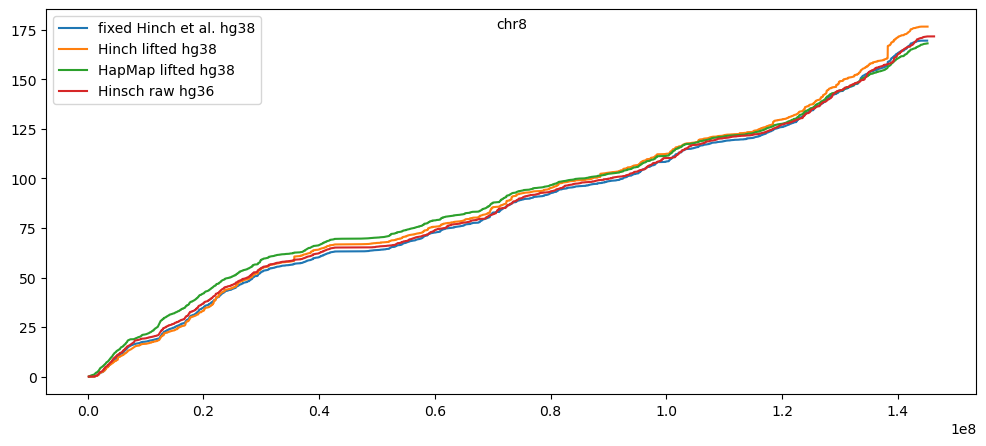

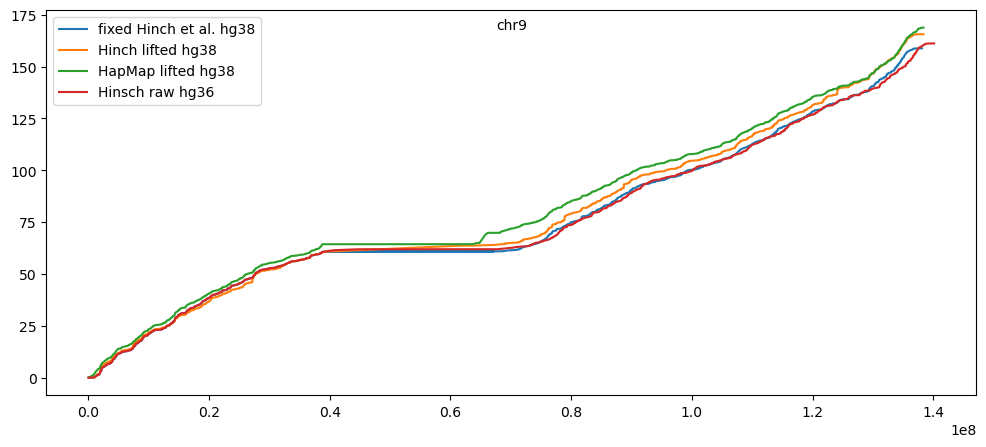

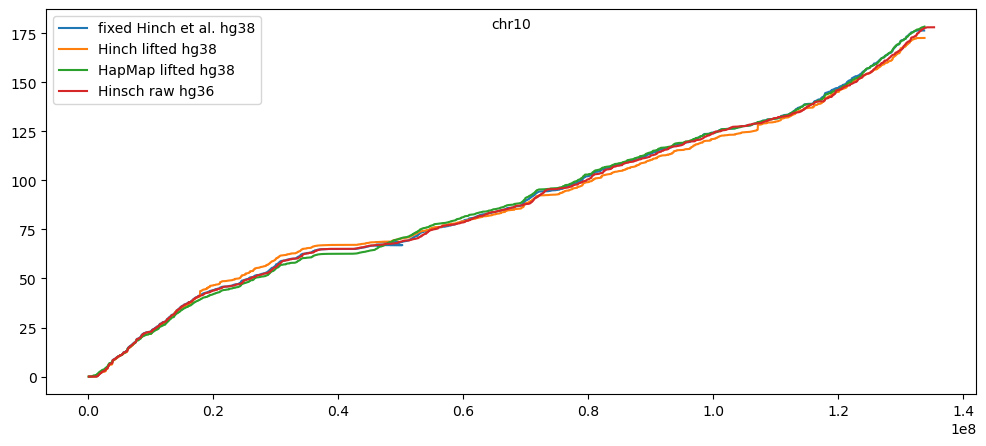

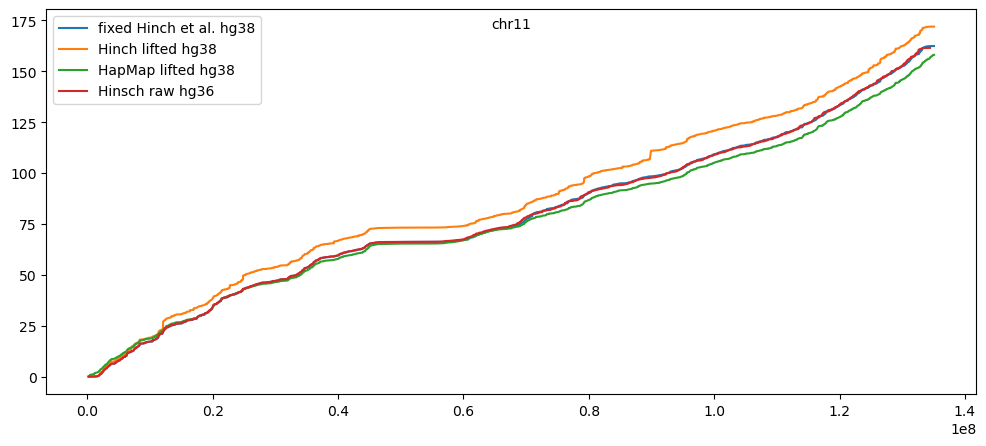

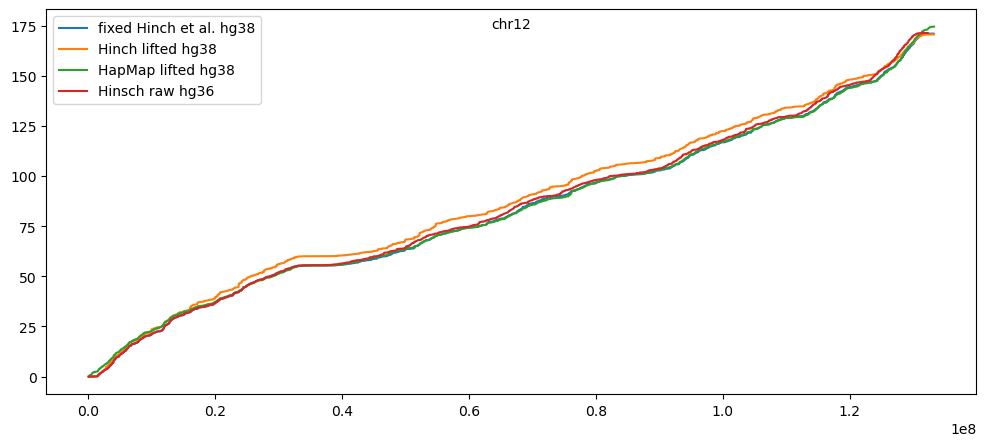

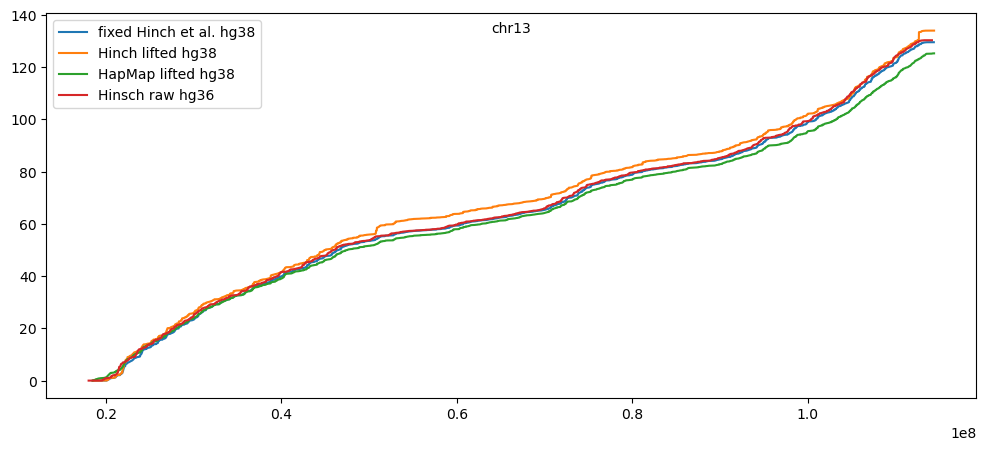

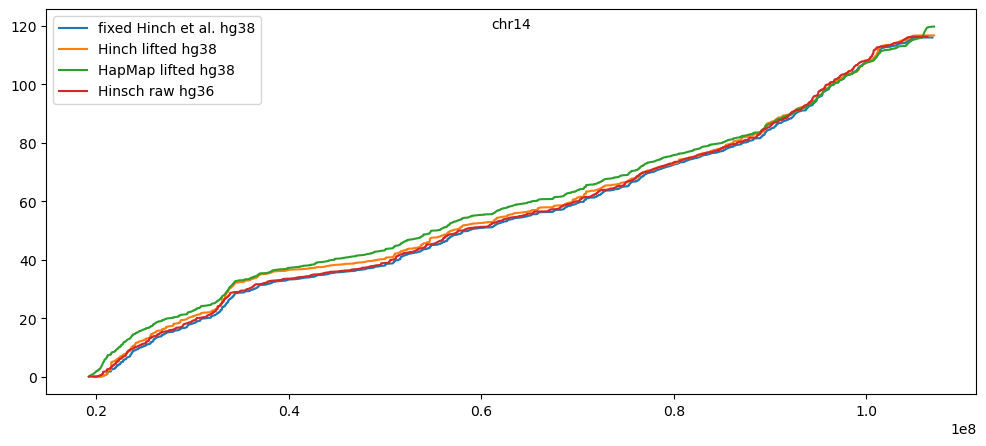

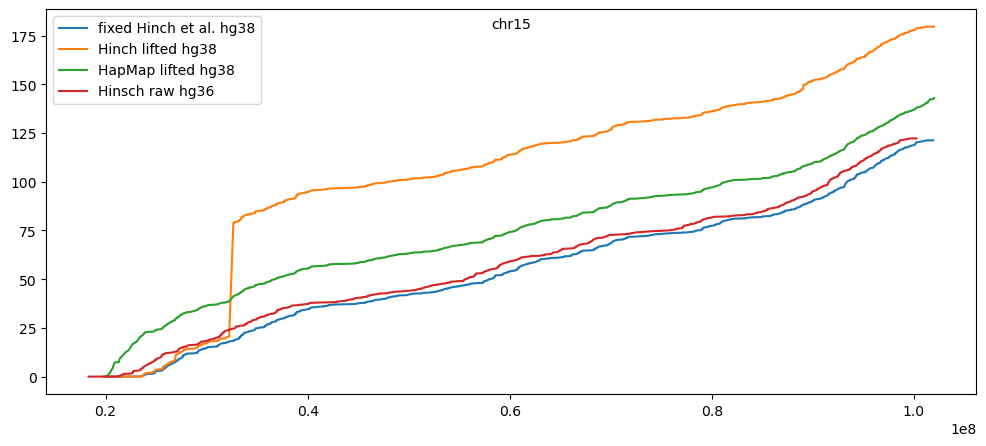

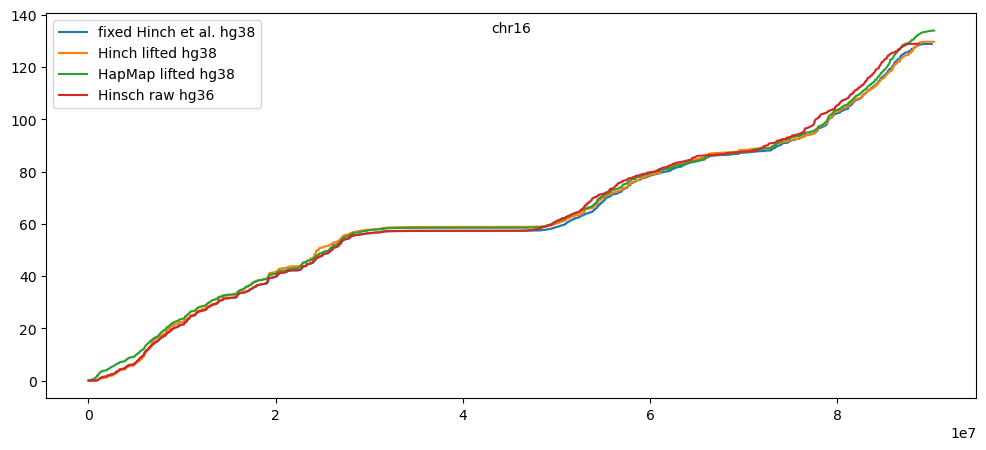

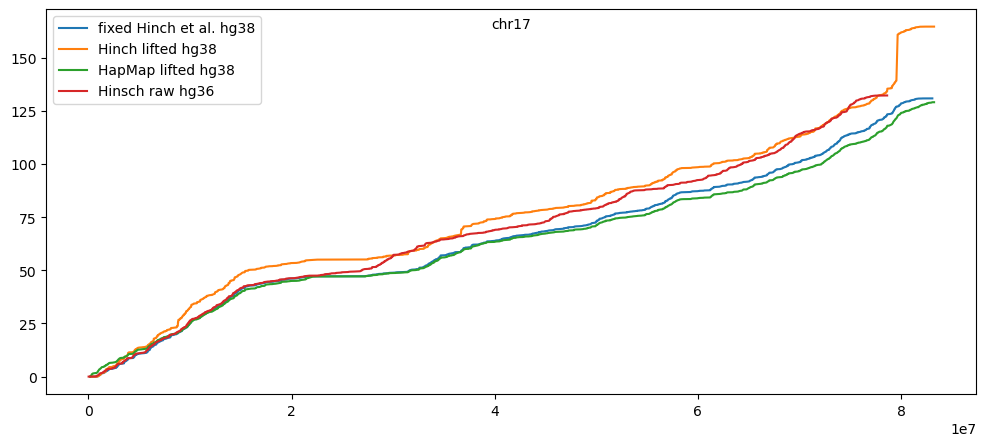

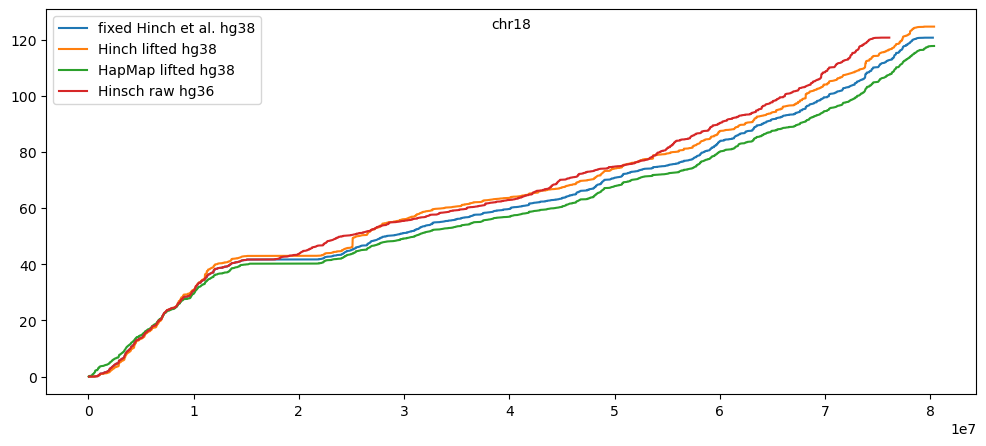

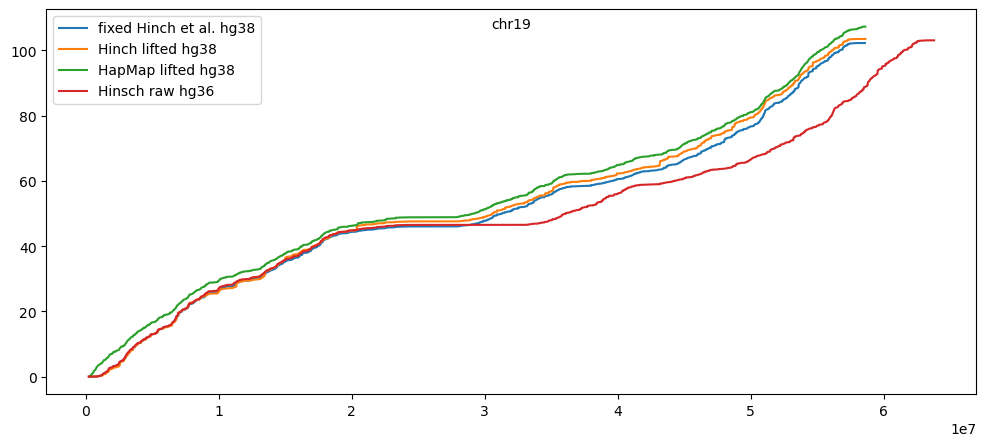

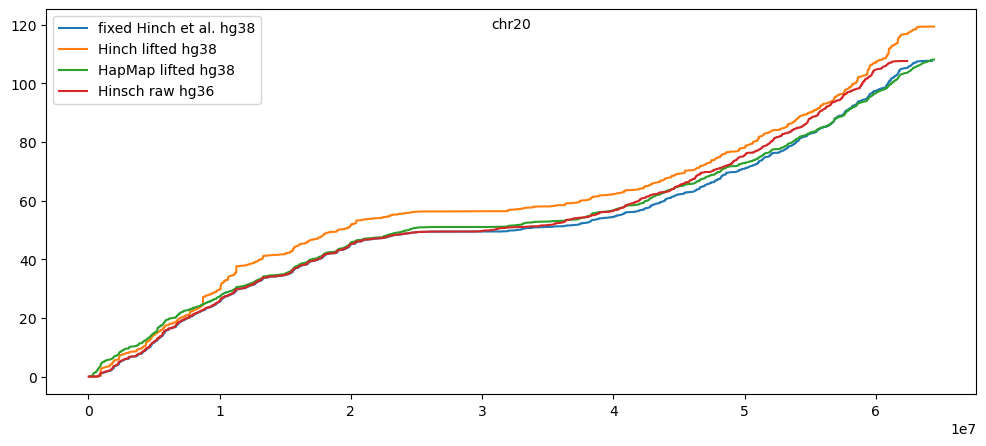

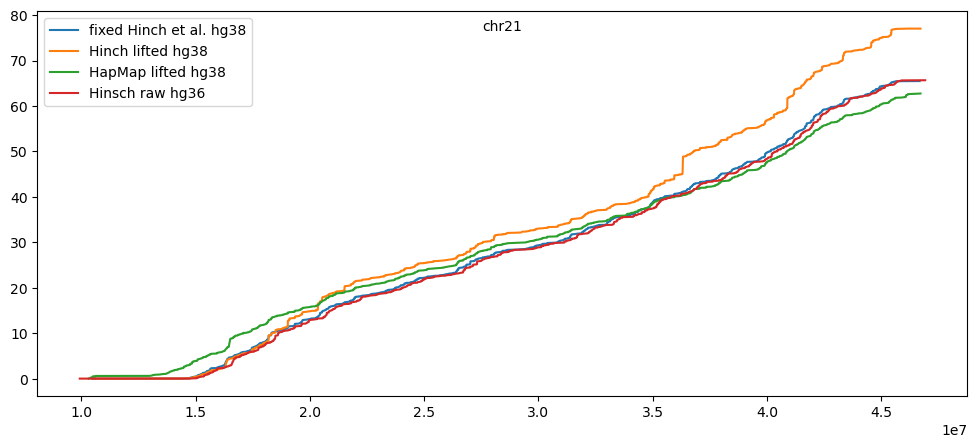

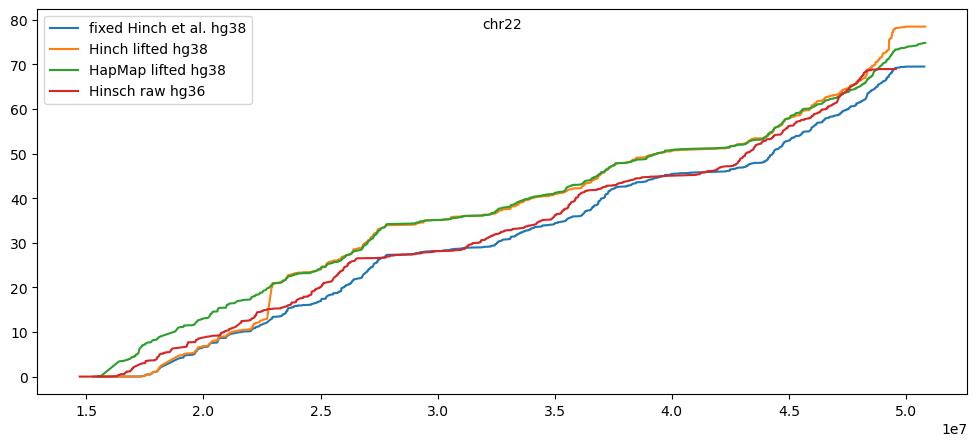

In [66]:
for i, chrom in enumerate(chroms):
    fig, fax = plt.subplots(figsize=(12, 5), sharex=True, sharey=True)
    row, col = entries[i]
    dc = dfixed.loc[dfixed['chrom'] == chrom]
    
    fax.plot(dc['end'], dc['cum'], label='fixed Hinch et al. hg38')
    x, y = rm.cum_rates[chrom]
    fax.plot(x, y, label='Hinch lifted hg38')
    
    x, y = hm.cum_rates[chrom]
    fax.plot(x, 100*y, label='HapMap lifted hg38')
    
    if chrom in raw_hirsh:
        dh = raw_hirsh[chrom]
        x, y = dh['pos'], dh['rate']
        fax.plot(x, y, label='Hinsch raw hg36')
    
    fax.text(0.5, 0.95, chrom, fontsize=10, 
             horizontalalignment='center',
             transform=fax.transAxes)
    fax.legend()

### Validate RecMap Object

In [19]:
rm = RecMap('../data/annotation/aamap_hg38.bed', 
            seqlens=hg38sl, conversion_factor=1)

FileNotFoundError: [Errno 2] No such file or directory: '../data/annotation/aamap_hg38.bed'

In [ ]:
for i, chrom in enumerate(chroms):
    fig, fax = plt.subplots()
    x
    fax.plot(x, y)
    dc = dx.loc[dx['chrom'] == chrom]
    fax.plot(dc['end'], dc['cumm'], label='fixed Hinch et al. hg38')

### New 

In [ ]:
d = np.loadtxt('../data/annotation/aamap_hg38.bed', skiprows=1,
              dtype={'names': ('chrom', 'end', 'rate'),
                     'formats': ('S5', 'int', 'float')})
seqlens = hg38sl

from collections import defaultdict

rates = defaultdict(list)

for i in range(d.shape[0]):
    row = d[i]
    chrom, end, rate = row
    chrom = chrom.decode()
    rates[chrom].append((end, rate))
    
for chrom, data in rates.items():
    end = seqlens[chrom]
    if data[-1][0] > end:
        raise ValueError(f"{chrom} has an end passed the reference sequence!")
    elif data[-1][0] < end:
        data.append((end, np.nan))
    # else: it goes to the end, everything's good
    if data[0][0] != 0:
        assert data[0][0] > 0 # no negative positions
        # we need to pre-prend zero
        data.insert(0, (0, np.nan))